# Interacting with open_clip

This is a self-contained notebook that shows how to download and run open_clip models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

## Preparation for colab

In [54]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [13]:
! pip install open_clip_torch matplotlib

In [14]:
import numpy as np
import torch

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [15]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_b79k'),
 ('ViT-g-14', 'laion2b_s12b_

In [19]:
model, preprocess, tokenizer = open_clip.create_model_and_transforms(
    'ViT-B-16',
    pretrained='laion400m_e31'
)


In [21]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

Model parameters: 149,620,737


In [38]:
import open_clip

model, _, _ = open_clip.create_model_and_transforms(
    'ViT-B-16',
    pretrained='laion400m_e31'
)

# ---- Tokenizer info: open_clip returns a tokenize function with no attributes ----
context_length = 77       # fixed for OpenCLIP
vocab_size = 49408        # fixed for OpenCLIP

print("Context length:", context_length)
print("Vocab size:", vocab_size)

# ---- Model internals ----
text_dim   = model.text_projection.shape[1]
vision_dim = model.visual.proj.shape[1]

print("Text embedding dim:", text_dim)
print("Vision embedding dim:", vision_dim)
print("Transformer blocks:", model.transformer.layers)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Context length: 77
Vocab size: 49408
Text embedding dim: 512
Vision embedding dim: 512
Transformer blocks: 12
Total parameters: 149,620,737


In [ ]:
# model.eval()

# context_length = model.context_length
# vocab_size = model.config.vocab_size

# print("Model parameters:", f"{sum(p.numel() for p in model.parameters()):,}")
# print("Context length:", context_length)
# print("Vocab size:", vocab_size)


AttributeError: 'CLIP' object has no attribute 'context_length'

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [40]:
preprocess

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
    <function _convert_to_rgb at 0x00000194163BCAF0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `tokenizer.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [41]:
from open_clip import tokenizer

In [42]:
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
!pip install scikit-image


In [45]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

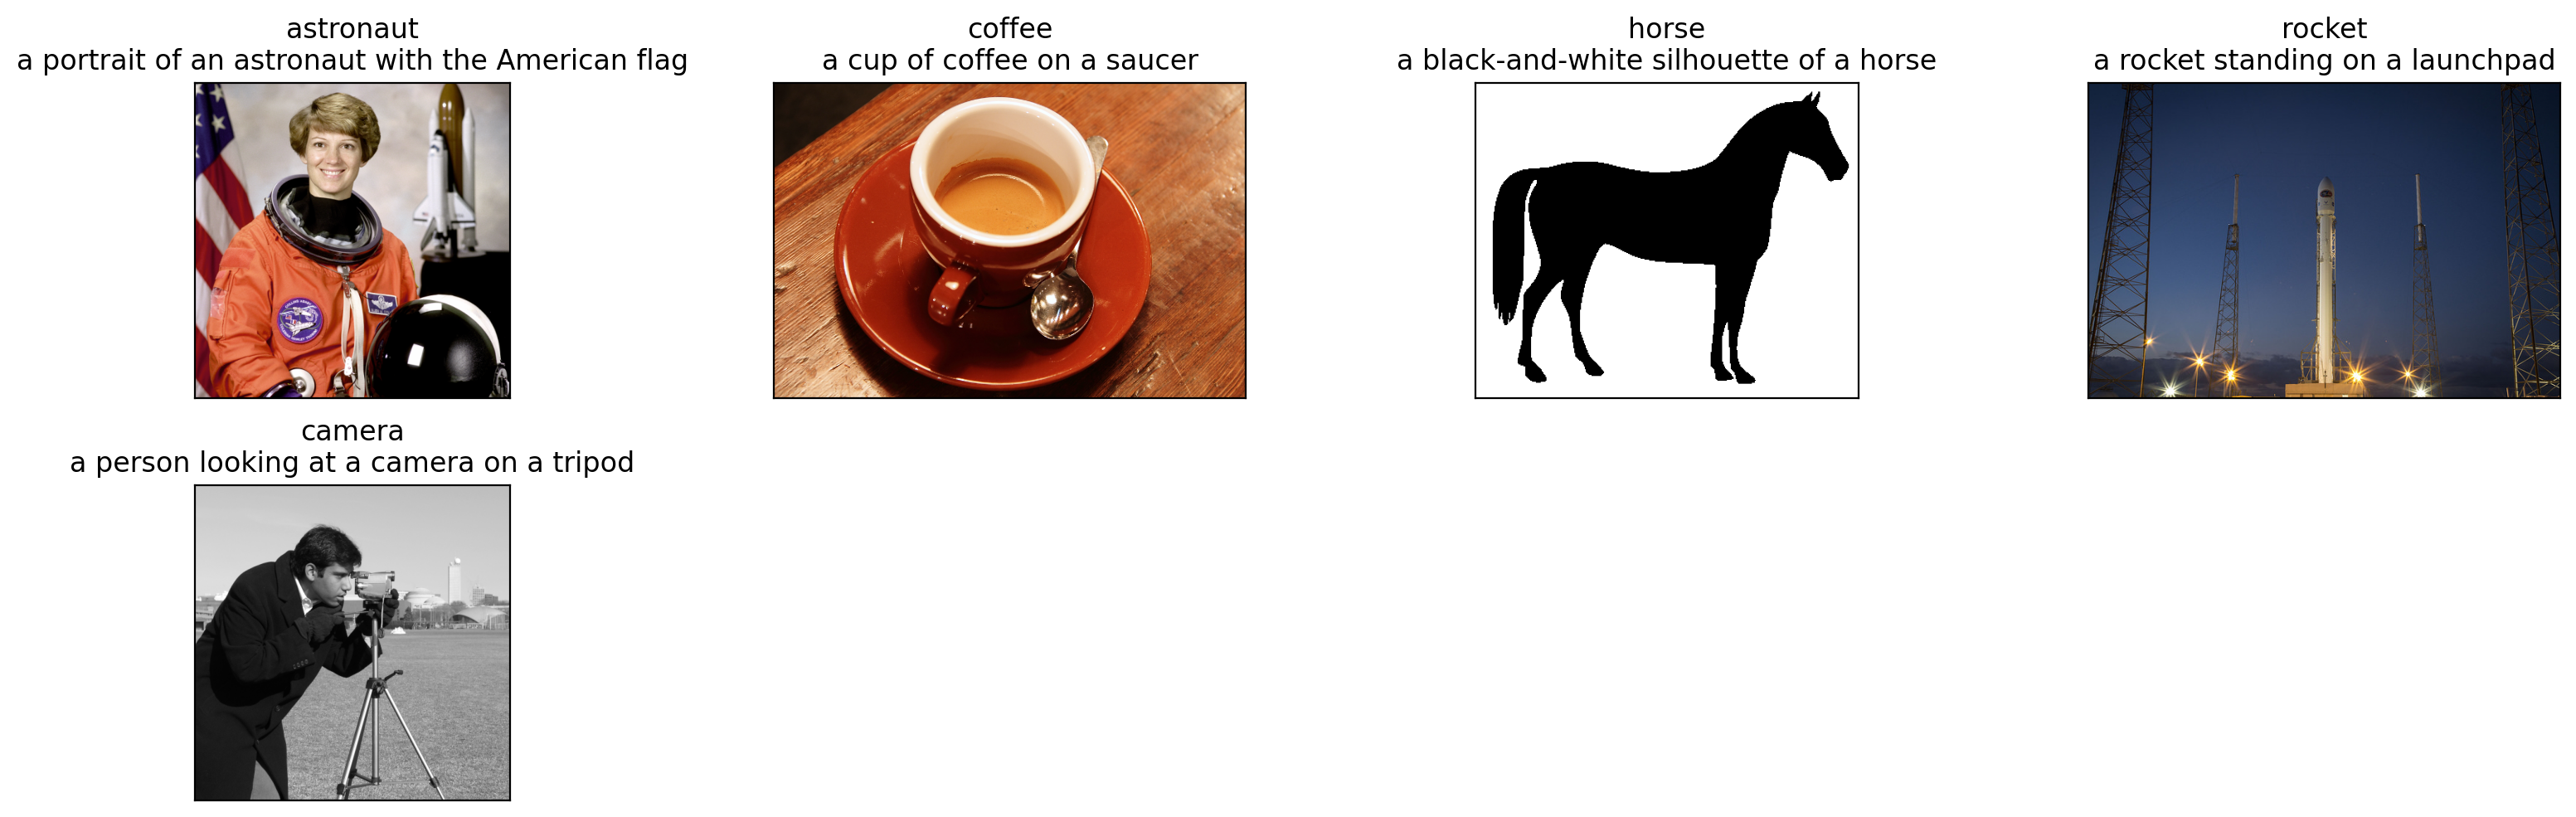

In [46]:
# original_images = []
# images = []
# texts = []
# plt.figure(figsize=(16, 5))

# for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
#     name = os.path.splitext(filename)[0]
#     if name not in descriptions:
#         continue

#     image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

#     plt.subplot(2, 4, len(images) + 1)
#     plt.imshow(image)
#     plt.title(f"{filename}\n{descriptions[name]}")
#     plt.xticks([])
#     plt.yticks([])

#     original_images.append(image)
#     images.append(preprocess(image))
#     texts.append(descriptions[name])

# plt.tight_layout()



from skimage import data

# dictionary of sample images and their descriptions
sample_images = {
    "astronaut": data.astronaut(),
    "cat": data.cat(),
    "coffee": data.coffee(),
    "horse": data.horse(),
    "rocket": data.rocket(),
    "camera": data.camera(),
}

original_images = []
images = []
texts = []

plt.figure(figsize=(16, 5))

for idx, (name, img) in enumerate(sample_images.items()):
    if name not in descriptions:
        continue

    # convert numpy array to PIL Image
    image = Image.fromarray(img).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{name}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [47]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [48]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [49]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

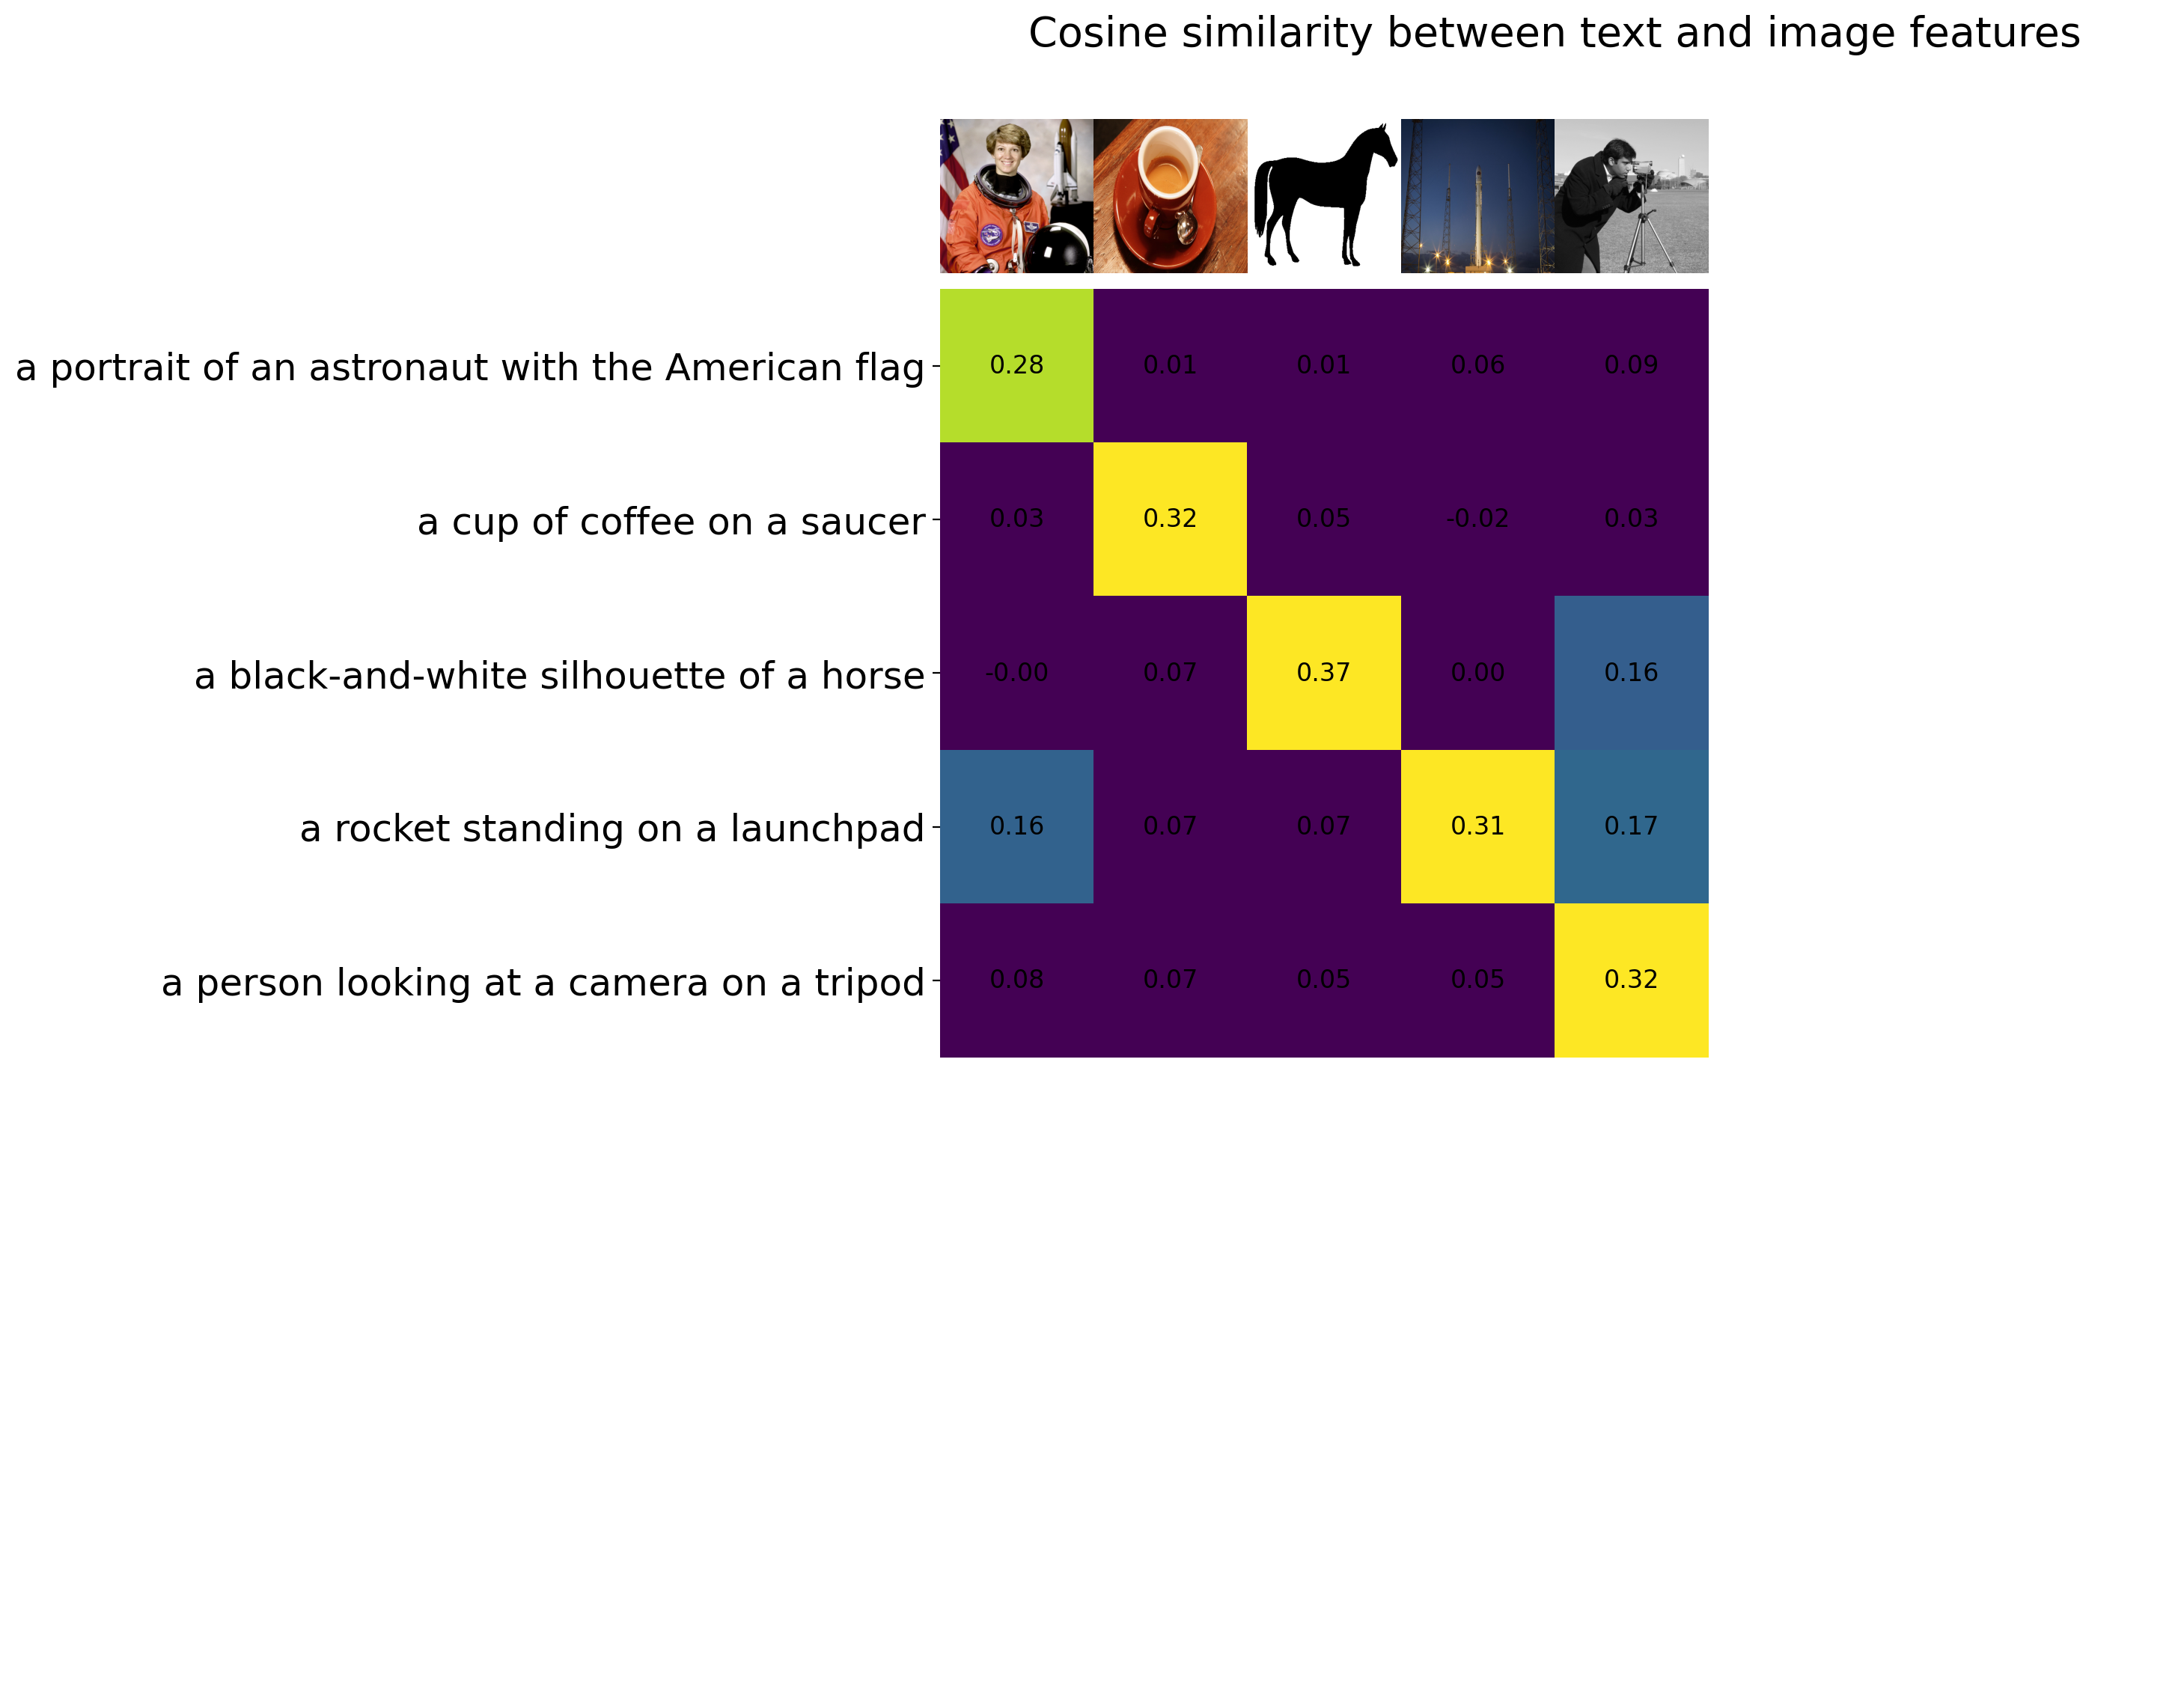

In [50]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(len(texts)), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

Device: cuda
Files already downloaded and verified


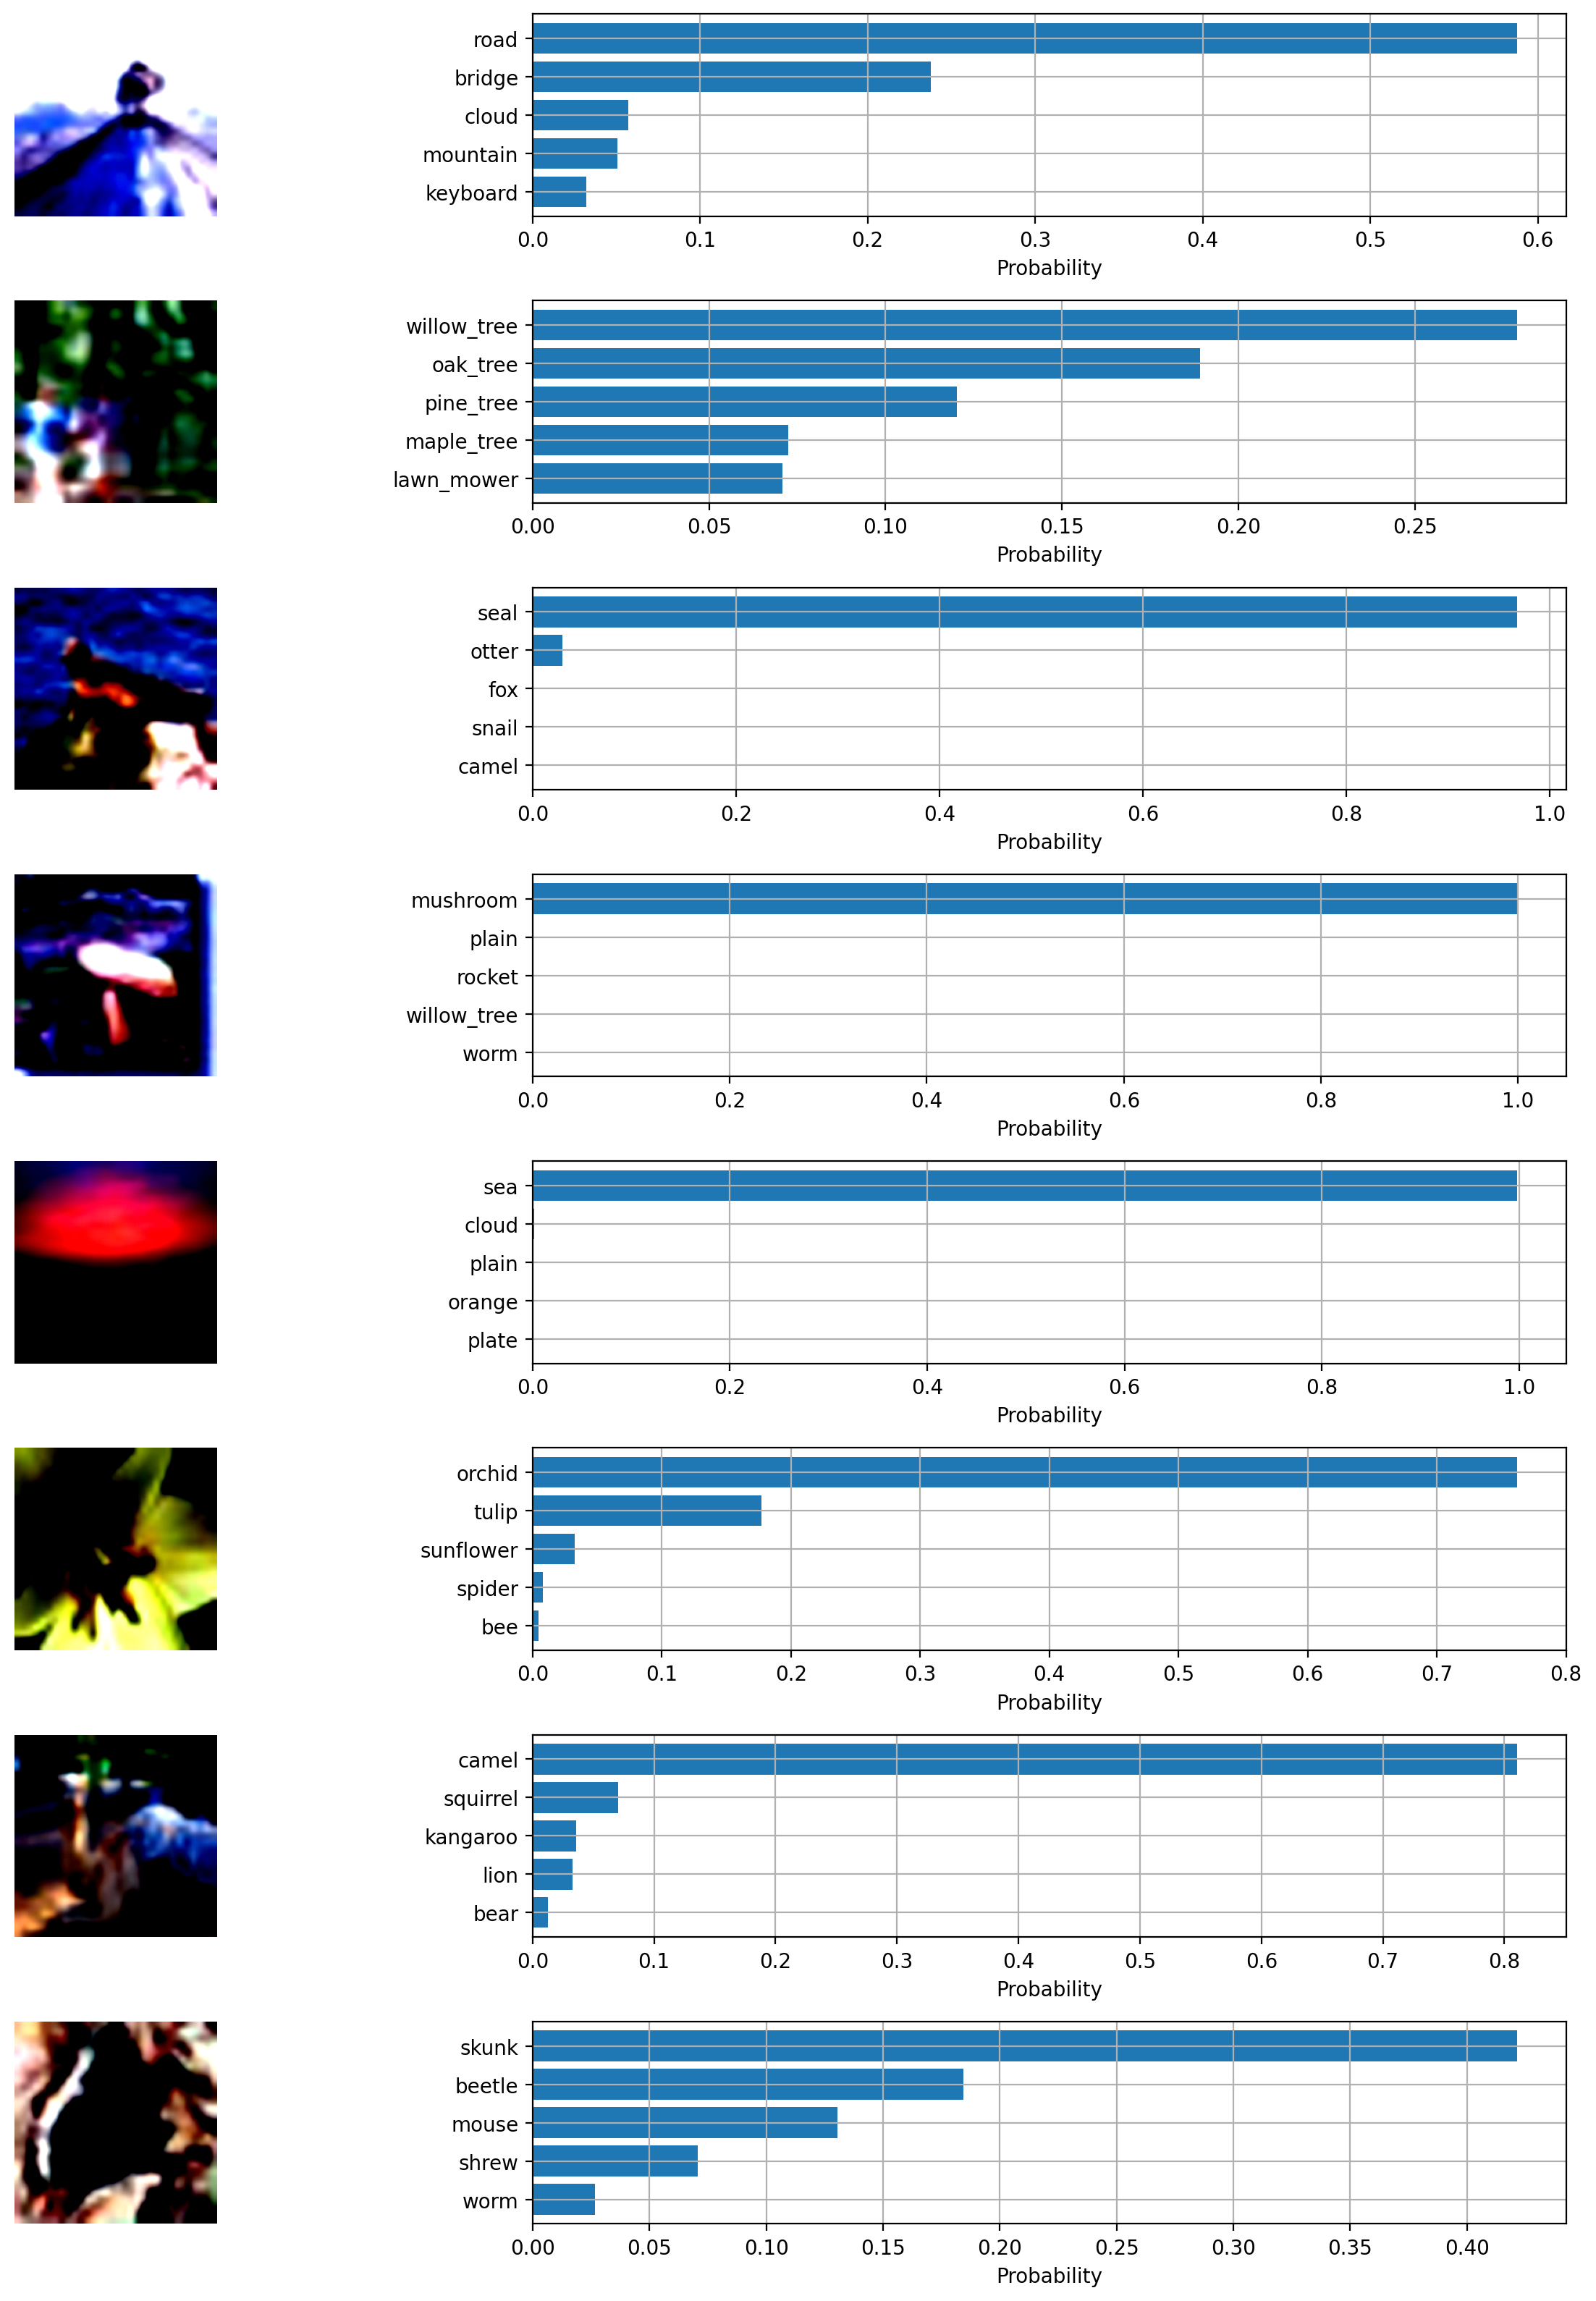

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import open_clip
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load model
model, preprocess, _ = open_clip.create_model_and_transforms(
    'ViT-B-16',
    pretrained='laion400m_e31'
)
tokenizer = open_clip.get_tokenizer('ViT-B-16')
model = model.to(device)

# Load dataset
cifar100 = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=preprocess
)

# Load batch of images (e.g., 8 images)
batch_size = 8
loader = DataLoader(cifar100, batch_size=batch_size, shuffle=False)
images, labels = next(iter(loader))
images = images.to(device)

# Text prompts
prompts = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer(prompts).to(device)

# Encode
with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text_tokens)

# Normalize
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = similarity.topk(5, dim=-1)

# Plot results
plt.figure(figsize=(14, batch_size * 2))

for i in range(batch_size):
    # Show image
    plt.subplot(batch_size, 2, 2*i + 1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    plt.axis("off")

    # Bar chart
    plt.subplot(batch_size, 2, 2*i + 2)
    y = np.arange(5)
    plt.barh(y, top_probs[i].cpu())
    plt.gca().invert_yaxis()
    plt.yticks(y, [cifar100.classes[idx] for idx in top_labels[i].cpu().numpy()])
    plt.xlabel("Probability")
    plt.grid(True)

plt.tight_layout()
plt.show()


Files already downloaded and verified


NameError: name 'batch_size' is not defined

In [69]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)

def get_features(dataset):
    all_features = []
    all_labels = []

    dataloader = DataLoader(dataset, batch_size=100)

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            features = model.encode_image(images.to(device))

            # 🔥 IMPORTANT: Normalize CLIP embeddings
            features = features / features.norm(dim=-1, keepdim=True)

            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

# Extract features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Convert to numpy (scikit-learn requirement)
train_features = train_features.numpy()
train_labels = train_labels.numpy()
test_features = test_features.numpy()
test_labels = test_labels.numpy()

# Train classifier
classifier = LogisticRegression(
    random_state=0,
    C=0.316,
    max_iter=1000,
    verbose=1,
    n_jobs=-1
)
classifier.fit(train_features, train_labels)

# Evaluate
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [02:15<00:00,  1.36s/it]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Accuracy = 79.920
